In [1]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')
# Check if a GPU is available
if torch.cuda.is_available():
    # Set the default device to GPU
    torch.cuda.set_device(0)  # You can specify the GPU index (0, 1, etc.) if you have multiple GPUs
else:
    print("No GPU available. Switching to CPU.")

Using device: cuda


In [2]:
import numpy as np
from matplotlib import pyplot as plt
complex_data = np.load('../layer_array.npy')

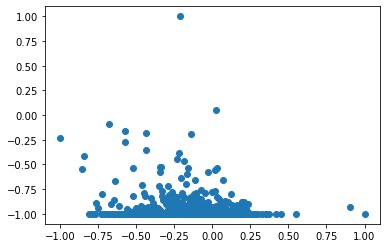

In [3]:
complex_data = torch.Tensor(complex_data) #array input
# transform to range [-1,1]
def transform(data):
    min_, max_ = torch.min(data, axis=1), torch.max(data, axis=1)
    data_transformed = 2 * (data.sub(min_.values[:, None])).div((max_.values - min_.values)[:, None]) - 1
    return data_transformed, min_, max_
data_transformed, min_, max_ = transform(complex_data[:2, :])
data_transformed = data_transformed
plt.scatter(data_transformed[0], data_transformed[1])

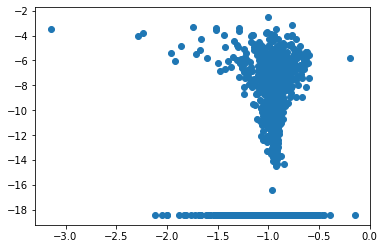

In [4]:
# transform to log
noise = 1e-8
def transform_log(data):
    return torch.log(complex_data+noise)
data_log = transform_log(complex_data[:2, :])
plt.scatter(data_log[0], data_log[1])

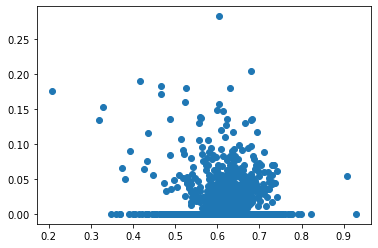

In [5]:
# transform to log
def transform_sqrt(data):
    return torch.sqrt(complex_data)
data_sqrt = transform_sqrt(complex_data[:2, :])
plt.scatter(data_sqrt[0], data_sqrt[1])

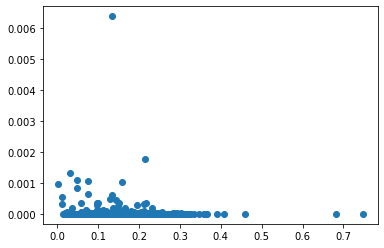

In [6]:
def masked_sqrt(data):
    result = []
    for num in data:
        if num < 0:
            result.append(-num ** 2)
        else:
            result.append(num ** 2)
    return result
y_sqrt = masked_sqrt(complex_data[0])
x_sqrt = masked_sqrt(complex_data[1])
plt.scatter(y_sqrt,x_sqrt)

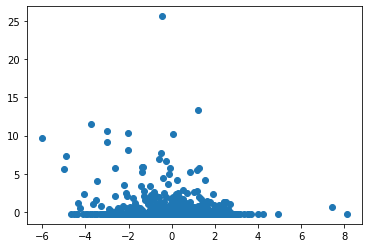

In [7]:
def data_norm(data):
    data_std = torch.std(data,axis=0)
    data_mean = torch.mean(data,axis=0)
    return (data-data_mean)/data_std
def np_data_norm(data):
    data_std = np.std(data,axis=0)
    data_mean = np.mean(data,axis=0)
    return (data-data_mean)/data_std
plt.scatter(data_norm(complex_data[0]), data_norm(complex_data[1]))

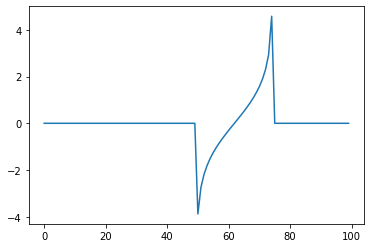

In [8]:
def logit(x):             
    alpha = 1e-6
    x = alpha + (1 - 2*alpha)*x
    return np.ma.log(x/(1-x)).filled(0)
x11 = np.linspace(-2,2,100)
plt.plot(logit(x11))

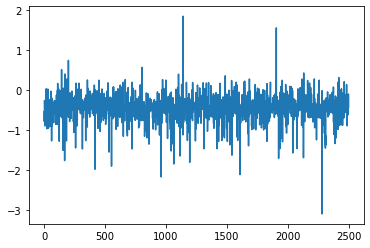

In [9]:
plt.plot(logit(complex_data[0]))

According to .json file stored in `preprocessing` directory, doing this before heading to the training

In [10]:
def CalcPreprocessing(data,fname):
    '''Apply data preprocessing'''
    
    data_dict = {
        'max':np.max(data,0).tolist(),
        'min':np.min(data,0).tolist(),
    }

    data = np.ma.divide(data-data_dict['min'],np.array(data_dict['max'])- data_dict['min']).filled(0)
    data = logit(data)
        
    mean = np.average(data,axis=0)
    std = np.std(data,axis=0)
    data_dict['mean']=mean.tolist()
    data_dict['std']=std.tolist()    
    SaveJson(fname,data_dict)

    data = (np.ma.divide((data-data_dict['mean']),data_dict['std']).filled(0)).astype(np.float32)
    
    print("done!")
    return data


def ApplyPreprocessing(data,fname):
    data_dict = LoadJson(fname)
    data = np.ma.divide(data-data_dict['min'],np.array(data_dict['max'])- data_dict['min']).filled(0)
    data = logit(data)
    data = (np.ma.divide((data-data_dict['mean']),data_dict['std']).filled(0)).astype(np.float32)
    return data
    

def SaveJson(save_file,data,base_folder='JSON'):
    with open(os.path.join(base_folder,save_file),'w') as f:
        json.dump(data, f)

    
def LoadJson(file_name,base_folder='JSON'):
    import json,yaml
    JSONPATH = os.path.join(base_folder,file_name)
    return yaml.safe_load(open(JSONPATH))